# Random numbers generation

This notebook aims to gently introduce to pseudo-random numbers generation, presenting some underlying concepts, and the implementation favors readability over speed. Efficient implementations are avaible on the net, and should be considered for serious purposes.

## Linear congruential generators

We first consider general LCGs, of the form
$$
x_{k+1} = a x_k +c \mod m.
$$

Adapted from https://rosettacode.org/wiki/Linear_congruential_generator

In [1]:
function getlcg(seed::Integer, a::Integer, c::Integer, m::Integer)
    state = seed
    am_mil = 1.0/m
    return function lcgrand()
        state = mod(a * state + c, m)
        return state*am_mil  # produce a number in (0,1)
    end
end

getlcg (generic function with 1 method)

Standard minimal generator:

In [2]:
stdmin = getlcg(1234, 16807, 0, 2^31-1)

(::var"#lcgrand#3"{Int64, Int64, Int64, Float64}) (generic function with 1 method)

In [3]:
n = 10000

sample = zeros(n)

for i = 1:n
    sample[i] = stdmin()
end

In [4]:
using Plots

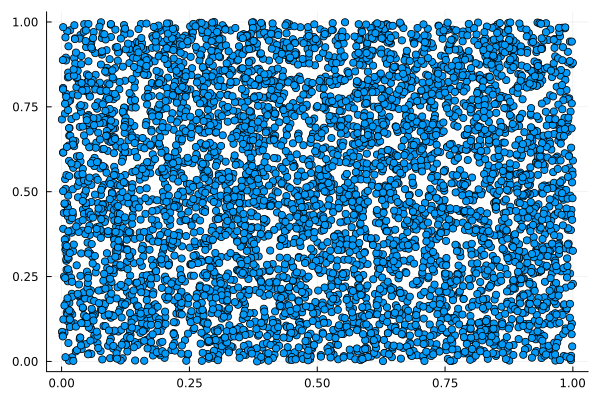

In [5]:
scatter(sample[[2*i+1 for i = 0:(Int)(n/2)-1]], sample[[2*i for i = 1:(Int)(n/2)]], label="", fmt = :png)

## RDST

Implementation of random streams.

In [6]:
import Pkg

Pkg.add(url = "https://github.com/JLChartrand/RDST.jl")

    Updating git-repo `https://github.com/JLChartrand/RDST.jl`
    Updating registry at `C:\Users\slash\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\slash\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\slash\.julia\environments\v1.9\Manifest.toml`


In [7]:
using RDST

### MRG32K3a

In [8]:
mrg_gen1 = MRG32k3aGen([1,2,3,4,5,6])

Seed for next MRG32k3a generator:
[1, 2, 3, 4, 5, 6]

In [9]:
typeof(mrg_gen1)

MRG32k3aGen

In [10]:
mrg_gen1 = MRG32k3aGen()

Seed for next MRG32k3a generator:
[12345, 12345, 12345, 12345, 12345, 12345]

The `show` function prints the current seed of the generator.

In [11]:
show(mrg_gen1)

Seed for next MRG32k3a generator:
[12345, 12345, 12345, 12345, 12345, 12345]

In [12]:
mrg_1 = next_stream(mrg_gen1)

Full state of MRG32k3a generator:
Cg = [12345, 12345, 12345, 12345, 12345, 12345]
Bg = [12345, 12345, 12345, 12345, 12345, 12345]
Ig = [12345, 12345, 12345, 12345, 12345, 12345]

In [13]:
typeof(mrg_1)

MRG32k3a

In [14]:
mrg_1 = next_stream(mrg_gen1)

Full state of MRG32k3a generator:
Cg = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]
Bg = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]
Ig = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]

In [15]:
stream1a = [rand(mrg_1) for i in 1:10]
reset_substream!(mrg_1)
stream1b = [rand(mrg_1) for i in 1:10]
stream1a == stream1b

true

In [16]:
show(mrg_gen1)

Seed for next MRG32k3a generator:
[1015873554, 1310354410, 2249465273, 994084013, 2912484720, 3876682925]

In [17]:
next_substream!(mrg_1)

Full state of MRG32k3a generator:
Cg = [3119395571, 2178405402, 1065030501, 3980307777, 2117495919, 1836828492]
Bg = [3119395571, 2178405402, 1065030501, 3980307777, 2117495919, 1836828492]
Ig = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]

In [18]:
stream2a = [rand(mrg_1) for i in 1:10]
reset_stream!(mrg_1)

Full state of MRG32k3a generator:
Cg = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]
Bg = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]
Ig = [3692455944, 1366884236, 2968912127, 335948734, 4161675175, 475798818]

In [19]:
next_substream!(mrg_1)
stream2b = [rand(mrg_1) for i in 1:10]
stream2a == stream2b

true

In [20]:
reset_stream!(mrg_1)
mrg_2 = next_stream(mrg_gen1)

Full state of MRG32k3a generator:
Cg = [1015873554, 1310354410, 2249465273, 994084013, 2912484720, 3876682925]
Bg = [1015873554, 1310354410, 2249465273, 994084013, 2912484720, 3876682925]
Ig = [1015873554, 1310354410, 2249465273, 994084013, 2912484720, 3876682925]

## Nonuniform distributions

For continuous random variables, the inversion technique is equivalent to compute the quantile associated to the realization of a uniform random variable $U(0,1)$. We will use the distributions package.

In [21]:
using Distributions

In [22]:
N = Normal()
α = quantile(N, 0.975)

1.9599639845400576

Normally distributed number generation:

In [23]:
quantile(N, rand())

1.7391377061936604

We can measure the required generation time with the package BenchmarkTools.

In [24]:
using BenchmarkTools

In [25]:
function InvertNormal()
    U = rand(Float64, 2)
    return quantile(N, U[1]), quantile(N, U[2])
end

InvertNormal (generic function with 1 method)

In [26]:
@btime X, Y = InvertNormal()

  150.244 ns (6 allocations: 176 bytes)


(1.0830548919786651, 0.7999062458687234)

In [27]:
function BoxMuller()
    U = rand(Float64, 2)
    
    R = sqrt(-2*log(U[1]))
    θ = 2*π*U[2]
    
    X = R*cos(θ)
    Y = R*sin(θ)
    
    return X, Y
end

BoxMuller (generic function with 1 method)

In [28]:
@btime X, Y = BoxMuller()

  61.100 ns (1 allocation: 80 bytes)


(-1.1958613405453422, -0.35488621321536157)

In [29]:
randn()

-1.6052924816737317

In [30]:
@btime randn()

  5.400 ns (0 allocations: 0 bytes)


1.2442011830584765